In [44]:
import cvxpy
import numpy as np
import qutip
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

plt.rc('text', usetex=True)
# mpl.style.use('seaborn-v0_8-paper')

mpl.rcParams['text.usetex'] = True
plt.rcParams['lines.linewidth'] = 1.3
plt.rcParams['figure.constrained_layout.use'] = True
mpl.rcParams['pgf.preamble'] = r'\usepackage{amsmath} \usepackage{amssymb}'

# General definitions

In [11]:
def MaSMeNoS_SDP_diag(lvecs,Fdiag,ρ, dρ):
    # This function implements the diagonal formulation in Eq. (28) of https://arxiv.org/pdf/2312.02035v1.pdf (first line)
    # lvecs is an array of numpy vectors [ l1  , l2 , ... , lnpar ] each vector has length `outcomes`
    # Fdiag is a npar numpy array containing the elements of the diagonal FI matrix (i.e. the eigenvalues of the original FI matrix)
    # ρ is a dim × dim numpy matrix
    # dρ is an array of dim × dim numpy matrices [ ∂1 ρ  , ∂2 ρ , ... , ∂npar ρ ] (this is already assumed in the parametrization in which the FI matrix is diagonal)

    dim = np.size(ρ,axis=0)
    npar = np.size(lvecs,axis=0)
    outcomes = np.size(lvecs,axis=1)

    # This converts the array of numpy arrays (indexed as lvecs[i][j]) to a 2D numpy array (indexed as lvecs[i,j])
    # TODO: decide if it's better to take this form as input already
    larray=np.array(lvecs) 
    
    obj_func = []
    POVM_N = []
    constraints = []

    for i in range(outcomes):
        # Create a cvxpy optimization variable that is hermitian (important, otherwise assumed to be a real matrix)
        POVM_N.append(cvxpy.Variable((dim, dim), hermitian=True))
        
        # Then we put the positivity constraints of POVMs
        constraints.append(  POVM_N[i] >> 0 )
        
        # The objective function element for each outcome
        lvec = larray[:,i]
        obj_func.append( cvxpy.real(cvxpy.trace( sum([ ((lvec[p]**2)*ρ - 2*lvec[p]*dρ[p])/Fdiag[p] for p in range(npar) ]) @ POVM_N[i] ) ) )
        # This form is the first line in Eq. (28) of https://arxiv.org/pdf/2312.02035v1.pdf not the second.

    # Normalization constraint of the POVM
    constraints.append(sum(POVM_N) == np.identity(dim))
    # constraints.append(sum(POVM_N) << np.identity(dim))

    objective = cvxpy.Maximize(npar + sum(obj_func))
    problem = cvxpy.Problem(objective, constraints)
    
    # return ( problem.solve(solver='MOSEK'), POVM_N)
    return problem.solve(solver='MOSEK')

def MeNoS_single_par(lvec, F, ρ, dρ):
    # Computes the single-parameter FI MeNoS, using the analytical formula from https://doi.org/10.1103/PhysRevLett.130.160802
    # lvec is a numpy array of length `outcomes`
    # F (the classical Fisher information) is a positive number
    # ρ (density operator) is a dim × dim numpy matrix
    # dρ (derivative of the density operator) is a dim × dim numpy matrix

    dim = np.size(ρ,axis=0)

    outcomes = len(lvec)
    
    lvec_sorted = np.sort(lvec)
    
    Amin = (lvec_sorted[0]**2)* ρ - 2*lvec_sorted[0] * dρ 
    Amax = (lvec_sorted[-1]**2)* ρ - 2*lvec_sorted[-1] * dρ 

    # nuclear norm = trace norm 
    return 1 + ( lvec_sorted[0]**2 + lvec_sorted[-1]**2 + np.linalg.norm(Amin - Amax,'nuc') ) /  (2*F)

def MaSMeNoS_diag_upper(lvecs,Fdiag,ρ, dρ):
    # This function implements the upper bound in Eq. (30) of https://arxiv.org/pdf/2312.02035v1.pdf 
    # This is just the sum of the single-par FI MeNoS for all parameters
    # lvecs is an array of numpy vectors [ l1  , l2 , ... , lnpar ] each vector has length `outcomes`
    # Fdiag is a npar numpy array containing the elements of the diagonal FI matrix (i.e. the eigenvalues of the original FI matrix)
    # ρ is a dim × dim numpy matrix
    # dρ is an array of dim × dim numpy matrices [ ∂1 ρ  , ∂2 ρ , ... , ∂npar ρ ] (this is already assumed in the parametrization in which the FI matrix is diagonal)

    dim = np.size(ρ,axis=0)
    npar = np.size(lvecs,axis=0)
    outcomes = np.size(lvecs,axis=1)
    
    upperbound = 0.
    for p in range(npar):
        upperbound = upperbound + MeNoS_single_par(lvecs[p], Fdiag[p], ρ, dρ[p])

    return upperbound

def MaSMeNoS_diag_lower(lvecs,Fdiag,ρ, dρ):
    # This function implements the lower bound in Eq. (29) of https://arxiv.org/pdf/2312.02035v1.pdf 
    # lvecs is an array of numpy vectors [ l1  , l2 , ... , lnpar ] each vector has length `outcomes`
    # Fdiag is a npar numpy array containing the elements of the diagonal FI matrix (i.e. the eigenvalues of the original FI matrix)
    # ρ is a dim × dim numpy matrix
    # dρ is an array of dim × dim numpy matrices [ ∂1 ρ  , ∂2 ρ , ... , ∂npar ρ ] (this is already assumed in the parametrization in which the FI matrix is diagonal)

    dim = np.size(ρ,axis=0)
    npar = np.size(lvecs,axis=0)
    outcomes = np.size(lvecs,axis=1)

    # This is superseeded by the next block of code, which does the same thing avoiding a matrix multiplication that was raising errors with single-parameter problems
    # if npar > 1:
    #     LL = np.diag(1/np.sqrt(Fdiag)) @ np.array(lvecs) # Each row of this matrix is now the vector L_α defined in https://arxiv.org/abs/2312.02035v1
    # else:
    #     LL = (1/np.sqrt(Fdiag)) * lvecs 

    LL = np.zeros_like(lvecs)
    for pp in range(npar):
        LL[pp,:]=lvecs[pp]/np.sqrt(Fdiag[pp])

    # This creates a 2D array of operators for all outcomes and parameter values
    # Beware this only works for the diagonal parametrization, it's not the full object in Eq. (14) of https://arxiv.org/pdf/2312.02035v1.pdf
    AopsDiag = [ [ (lvecs[p][α]**2)*ρ - 2*lvecs[p][α]*dρ[p] for α in range(outcomes)] for p in range(npar)] 

    # This creates an array that contains the value of the lower bound for all possible pairs of measurement outcomes
    Zs = []
    for α in range(outcomes):
        for β in range(α+1,outcomes):
            
            Op_tot= np.zeros_like(AopsDiag[0][0])
            for p in range(npar):
                Op_tot += (AopsDiag[p][α] - AopsDiag[p][β])/ (2*Fdiag[p])
                
            Zs.append( npar + 0.5*(np.linalg.norm(LL[:,α])**2 + np.linalg.norm(LL[:,β])**2) + np.linalg.norm(Op_tot,'nuc'))

    return np.max(Zs)

def FImat(pvec,lvec):
    # This computes the FI matrix given a vector of probabilities and an array of scores (logarithmic derivatives of the probability vector).
    # No consistency checks are performed.
    
    npar=len(lvec)
    mat=np.zeros((npar,npar))
    for i in range(npar):
        for j in range(npar):
            mat[i,j]=np.sum(lvec[i]*lvec[j]*pvec)
    return np.matrix(mat)

def QFI_SLD(rho,drhovec):
    # This function computes the QFI matrix given a density operator and an array of its partial derivatives.
    # For compactess, we apply the formula based on vectorization from https://doi.org/10.1103/PhysRevA.97.042322 
    # No consistency checks are performed.
    
    npar=len(drhovec)

    mat=np.zeros((npar,npar))
    
    Imat = np.identity(np.shape(rho)[1])
    
    Minv = np.linalg.pinv(np.kron(np.conjugate(rho),Imat) + np.kron(Imat,rho),hermitian=True)
            
    for i in range(npar):
        for j in range(npar):
            mat[i,j] = np.real((2*np.conjugate(np.matrix.flatten(drhovec[i],order='F')) @ Minv @ np.matrix.flatten(drhovec[j],order='F').T).item())
    return np.matrix(mat)

def prob_scores_from_meas(ρ,dρlist,M):
    # This function computes the probabilities and the scores for a POVM M on a given quantum statistical model, defined by a density operator ρ and a collection of its partical derivative dρlist
    # No consistency checks are performed
    
    outcomes = len(M)
    npar = len(dρlist)
    dim = dim = np.size(ρ,axis=0)

    p = np.array([ np.real(np.trace(m@ρ)) for m in M ])
    dp = []
    l = [ ]
    for k, dρ in enumerate(dρlist):
        dp.append( np.array([ np.real(np.trace(m@dρ)) for m in M ]) )
        l.append( dp[k]/p ) # need to add exception for p[i] = 0
    return (p,dp,l)

# Phase & dephasing estimation

### Definitions, separable and entangled measurements

Definition of the quantum statistical model

In [12]:
def phase_dephasing_qubit_model(φ,Δ):
        
    rho = 0.5*np.matrix( [[ 1. , np.exp(-Δ - 1j*φ) ], [np.exp(-Δ + 1j*φ) , 1. ]])
    dφrho = - 0.5j*np.matrix( [[ 0. , np.exp(-Δ - 1j*φ) ], [ - np.exp(-Δ + 1j*φ) , 0. ]],)
    dΔrho = - 0.5*np.matrix( [[ 0. , np.exp(-Δ - 1j*φ) ], [np.exp(-Δ + 1j*φ) , 0. ]] )
    
    return ( rho , [ dφrho , dΔrho ] )

The following parameter value of the phase will remail fixed

In [13]:
φval = np.pi/4 # for this value the FI is already diagonal 

Single-copy separable POVM and entangled 2-copy POVM:

In [14]:
M1= 0.25*np.matrix([ [1.	,1.], [1.,1.] ])
M2= 0.25* np.matrix([ [1.	, -1.], [-1.,1.] ])
M3= 0.25* np.matrix([ [1.	, 1j], [-1j,1.] ])
M4= 0.25* np.matrix( [[1.	, -1j], [1j,1.] ])
Mvec = [ M1, M2, M3, M4] 

Π1 = 0.5 * np.matrix([
    [1, 0, 0, 1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [1, 0, 0, 1]])
Π2 = 0.5 * np.matrix(
    [[1, 0, 0, -1],
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [-1, 0, 0, 1]])
Π3 = 0.5 * np.matrix(
    [[0, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0]])
Π4 = 0.5 * np.matrix(
    [[0, 0, 0, 0],
    [0, 1, -1, 0],
    [0, -1, 1, 0],
    [0, 0, 0, 0]])
M_2copies_vec = [ Π1, Π2, Π3, Π4]

Check that these are correctlynormalized:

In [15]:
sum(Mvec)

matrix([[1.+0.j, 0.+0.j],
        [0.+0.j, 1.+0.j]])

In [16]:
sum(M_2copies_vec)

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

## Results

### Figure 1: plot of susceptibility and optimality as a function of $\Delta$

In [18]:
Δspan = np.linspace(0.002,0.701,500)

upperΔ = []
lowerΔ = []
masmenosΔ = []
rΔ = []

upperΔ_2copies = []
lowerΔ_2copies = []
masmenosΔ_2copies = []
rΔ_2copies = []

for delta in Δspan:
    
    [rhotemp, drhotemp ] = phase_dephasing_qubit_model(φval,delta)
    (pp , dpp , ll ) = prob_scores_from_meas(rhotemp,drhotemp,Mvec)
    QFItemp = QFI_SLD(rhotemp,drhotemp)
    
    ρval_2copies = np.kron(rhotemp,rhotemp)
    dρval_2copies = [ np.kron(drho,rhotemp) + np.kron(rhotemp,drho)  for drho in drhotemp]
    (pp_2copies , dpp_2copies , ll_2copies ) = prob_scores_from_meas(ρval_2copies,dρval_2copies,M_2copies_vec)
    
    Fmat = FImat(pp,ll)
    Fdiag = np.diag(Fmat) # I know it's already diagonal

    rΔ.append(  np.trace( np.linalg.inv(Fmat)) / np.trace( np.linalg.inv(QFItemp)))

    Fmat_2copies = FImat(pp_2copies,ll_2copies)
    Fdiag_2copies = np.diag(Fmat_2copies) # I know it's already diagonal

    rΔ_2copies.append( 2*np.trace( np.linalg.inv(Fmat_2copies)) / np.trace( np.linalg.inv(QFItemp)))
    
    lowerΔ.append( MaSMeNoS_diag_lower(ll,Fdiag,rhotemp,drhotemp))
    masmenosΔ.append( MaSMeNoS_SDP_diag(ll,Fdiag,rhotemp,drhotemp))
    upperΔ.append( MaSMeNoS_diag_upper(ll,Fdiag,rhotemp,drhotemp))

    lowerΔ_2copies.append( MaSMeNoS_diag_lower(ll_2copies,Fdiag_2copies,ρval_2copies,dρval_2copies))
    masmenosΔ_2copies.append( MaSMeNoS_SDP_diag(ll_2copies,Fdiag_2copies,ρval_2copies,dρval_2copies))
    upperΔ_2copies.append( MaSMeNoS_diag_upper(ll_2copies,Fdiag_2copies,ρval_2copies,dρval_2copies))

# Since we have been lazy and used append, now it's better to transform these to numpy arrays 
lowerΔ=np.array(lowerΔ)
masmenosΔ=np.array(masmenosΔ)
upperΔ=np.array(upperΔ)
rΔ = np.array(rΔ)
lowerΔ_2copies=np.array(lowerΔ_2copies)
masmenosΔ_2copies=np.array(masmenosΔ_2copies)
upperΔ_2copies=np.array(upperΔ_2copies)
rΔ_2copies=np.array(rΔ_2copies)

Figure 1 in the paper

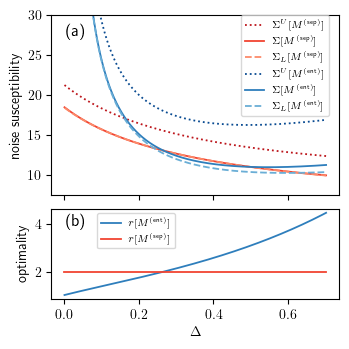

In [46]:
Δspan = np.array(Δspan)

cmap_reds = mpl.colormaps['Reds']
cmap_blues = mpl.colormaps['Blues']
redplot=cmap_reds(.6)
blueplot=cmap_blues(.7)

fig = plt.figure(figsize=(3.375,3.375),layout='constrained')

axs = fig.subplots(2,1,sharex=True,height_ratios=[2,1])

axs[0].plot(Δspan,upperΔ,label='$\Sigma^U[M^{\mathsf{(sep)}}]$',linestyle='dotted',color=cmap_reds(.8))
axs[0].plot(Δspan,masmenosΔ,label='$\Sigma[M^{\mathsf{(sep)}}]$',color=cmap_reds(.6))
axs[0].plot(Δspan,lowerΔ,label='$\Sigma_L[M^{\mathsf{(sep)}}]$',linestyle='dashed',color=cmap_reds(.4))


axs[0].plot(Δspan,upperΔ_2copies,label='$\Sigma^U[M^{\mathsf{(ent)}}]$',linestyle='dotted',color=cmap_blues(.9))
axs[0].plot(Δspan,masmenosΔ_2copies,label='$\Sigma[M^{\mathsf{(ent)}}]$',color=cmap_blues(.7))
axs[0].plot(Δspan,lowerΔ_2copies,label='$\Sigma_L[M^{\mathsf{(ent)}}]$',linestyle='dashed',color=cmap_blues(.5))

axs[0].set_ylabel('noise susceptibility')
axs[0].set_ylim(7.5,30)

axs[0].legend(fontsize='x-small',loc=(0.66,.44),fancybox=True, framealpha=0.75)

axs[0].text(0.05, 0.95, '(a)', transform=axs[0].transAxes,fontsize='large', va='top')


axs[1].plot(Δspan,rΔ_2copies,color=cmap_blues(.7),label=r'$r[M^{\mathsf{(ent)}}]$')
axs[1].plot(Δspan,rΔ,color=cmap_reds(.6),label=r'$r[M^{\mathsf{(sep)}}]$')

axs[1].legend(fontsize='x-small',loc=(0.16,.56),fancybox=True, framealpha=0.75)
axs[1].text(0.05, 0.95, '(b)', transform=axs[1].transAxes,fontsize='large', va='top')

axs[1].set_xlabel(r'$\Delta$')
axs[1].set_ylabel('optimality');

# fig2.savefig("phiDelta_varyingDeltaNEW.pdf")

# SPADE measurement for two incoherent point sources

The parameter vector is (in order)  $[s,s_0,q]$

In [32]:
def prob_scores_spade(s,s0,q,x0): 

    pvec = np.array( [1/147456 * ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( -3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( s * ( 12 + ( -4 * ( 2 )**( 1/2 ) * s0 + 4 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ),1/147456 * ( ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( -4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ),1/368640 * ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( 384 + ( 96 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( -384 + ( 96 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ),1/184320 * ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( -192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( 192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ),] )

    l1= np.array( [1/8 * ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( 16 * ( 6 )**( 1/2 ) + ( 12 * ( s + ( 2 * s0 + -2 * x0 ) ) + -1 * ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) ) * ( 256 * ( 6 )**( 1/2 ) + ( 384 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( -48 * ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -16 * ( 6 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -12 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) + ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( s + ( -2 * s0 + 2 * x0 ) ) * ( -256 * ( 6 )**( 1/2 ) + ( 384 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 48 * ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( 16 * ( 6 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( -12 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) + -1 * ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( s * ( 12 + ( -4 * ( 2 )**( 1/2 ) * s0 + 4 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( -3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( s * ( 12 + ( -4 * ( 2 )**( 1/2 ) * s0 + 4 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) )**( -1 ),1/8 * ( ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( s + ( -2 * s0 + 2 * x0 ) ) * ( -256 * ( 6 )**( 1/2 ) + ( -384 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 48 * ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( 16 * ( 6 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( 12 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) + -1 * ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( -4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) + -1 * ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( 256 * ( 6 )**( 1/2 ) + ( -384 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( -48 * ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -16 * ( 6 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( 12 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) + ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( s + ( 2 * s0 + -2 * x0 ) ) * ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( -4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) )**( -1 ),1/8 * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( 384 + ( 96 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( -384 + ( 96 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) )**( -1 ) * ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( 384 + ( 96 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) * ( 1536 + ( -384 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( -96 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( 48 * ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + -1 * ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( 384 + ( -96 * ( s + ( -2 * s0 + 2 * x0 ) ) + -1 * ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) * ( -1536 + ( -384 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 96 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( -48 * ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ),1/40 * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( -192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( 192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) )**( -1 ) * ( 5 * ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( -192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) * ( 512 * ( 3 )**( 1/2 ) + ( 192 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 48 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -32 * ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + -1 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) + 5 * ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( -192 * ( 3 )**( 1/2 ) + ( -32 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + -1 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) * ( -512 * ( 3 )**( 1/2 ) + ( 192 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + ( -48 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( 32 * ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ),] )
    
    l2=np.array( [1/4 * ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( 16 * ( 6 )**( 1/2 ) + ( 12 * ( s + ( 2 * s0 + -2 * x0 ) ) + -1 * ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) ) * ( 256 * ( 6 )**( 1/2 ) + ( 384 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( -48 * ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -16 * ( 6 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -12 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) + ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( s + ( -2 * s0 + 2 * x0 ) ) * ( 256 * ( 6 )**( 1/2 ) + ( -384 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( -48 * ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( -16 * ( 6 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( 12 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) + ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( s * ( 12 + ( -4 * ( 2 )**( 1/2 ) * s0 + 4 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( -3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( s * ( 12 + ( -4 * ( 2 )**( 1/2 ) * s0 + 4 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) )**( -1 ),1/4 * ( ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( s + ( -2 * s0 + 2 * x0 ) ) * ( 256 * ( 6 )**( 1/2 ) + ( 384 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( -48 * ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( -16 * ( 6 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( -12 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) + ( 2 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( -4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) + -1 * ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( 256 * ( 6 )**( 1/2 ) + ( -384 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( -48 * ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -16 * ( 6 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( 12 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) + ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) ) * ( s + ( 2 * s0 + -2 * x0 ) ) * ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( -4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) )**( -1 ),1/4 * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( 384 + ( 96 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( -384 + ( 96 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) )**( -1 ) * ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( 384 + ( 96 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) * ( 1536 + ( -384 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( -96 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( 48 * ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + -1 * ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( 384 + ( -96 * ( s + ( -2 * s0 + 2 * x0 ) ) + -1 * ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) * ( 1536 + ( 384 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( -96 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( 48 * ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + -1 * ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ),1/20 * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( -192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( 192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) )**( -1 ) * ( 5 * ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( -192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) * ( 512 * ( 3 )**( 1/2 ) + ( 192 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 48 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + ( -32 * ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + -1 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 4 ) ) ) ) ) + 5 * ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( -192 * ( 3 )**( 1/2 ) + ( -32 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + -1 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) * ( 512 * ( 3 )**( 1/2 ) + ( -192 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 48 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + ( -32 * ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) + -1 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 4 ) ) ) ) ) ),] )
    
    l3=np.array( [( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * ( ( 16 * ( 6 )**( 1/2 ) + ( 12 * ( s + ( 2 * s0 + -2 * x0 ) ) + -1 * ( 2 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) ) )**( 2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) + -1 * ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( s * ( 12 + ( -4 * ( 2 )**( 1/2 ) * s0 + 4 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( -3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( s * ( 12 + ( -4 * ( 2 )**( 1/2 ) * s0 + 4 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( 6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + -2 * s0 * ( 3 + ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) )**( -1 ),( -1 * ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( -4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( -4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) * ( ( ( 2 )**( 1/2 ) * ( s )**( 2 ) + ( 4 * s * ( 3 + ( ( 2 )**( 1/2 ) * s0 + -1 * ( 2 )**( 1/2 ) * x0 ) ) + 4 * ( -4 * ( 6 )**( 1/2 ) + ( ( 2 )**( 1/2 ) * ( s0 )**( 2 ) + ( -6 * x0 + ( ( 2 )**( 1/2 ) * ( x0 )**( 2 ) + s0 * ( 6 + -2 * ( 2 )**( 1/2 ) * x0 ) ) ) ) ) ) ) )**( 2 ) ) )**( -1 ),( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * ( ( 384 + ( 96 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + -1 * ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( ( -384 + ( 96 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( 384 + ( 96 * ( s + ( 2 * s0 + -2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( -384 + ( 96 * ( s + ( -2 * s0 + 2 * x0 ) ) + ( 3 )**( 1/2 ) * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) )**( -1 ),( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * ( ( -192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + -1 * ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( ( 192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) * ( ( ( np.e )**( -1/16 * ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 2 ) ) * q * ( ( -192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( 2 * s0 + -2 * x0 ) ) + ( ( s + ( 2 * s0 + -2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) + ( np.e )**( -1/16 * ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 2 ) ) * ( 1 + -1 * q ) * ( ( 192 * ( 3 )**( 1/2 ) + ( 32 * ( 3 )**( 1/2 ) * ( s + ( -2 * s0 + 2 * x0 ) ) + ( ( s + ( -2 * s0 + 2 * x0 ) ) )**( 3 ) ) ) )**( 2 ) ) )**( -1 ),] )

    return (pvec, [ l1  , l2 , l3 ])

In [33]:
def rho_drho_spade(s,s0,q):
    
    rho = np.array( [np.array( [1/2 * ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ),1/2 * ( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ),0,0,] ),np.array( [1/2 * ( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ),1/2 * ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ),0,0,] ),np.array( [0,0,0,0,] ),np.array( [0,0,0,0,] ),] );

    d1rho= np.array( [np.array( [-1/8 * ( np.e )**( -1/8 * ( s )**( 2 ) ) * s,1/8 * ( np.e )**( -1/4 * ( s )**( 2 ) ) * ( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( -1/2 ) * ( -1 + 2 * q ) * s,1/16 * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),1/16 * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( 4 + ( 4 * ( np.e )**( -1/8 * ( s )**( 2 ) ) + -1 * ( ( -1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( s )**( 2 ) ) ) )**( 1/2 ),] ),np.array( [1/8 * ( np.e )**( -1/4 * ( s )**( 2 ) ) * ( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( -1/2 ) * ( -1 + 2 * q ) * s,1/8 * ( np.e )**( -1/8 * ( s )**( 2 ) ) * s,1/16 * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),1/16 * ( 2 )**( -1/2 ) * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 * ( -1 + 1/np.tanh( 1/16 * ( s )**( 2 ) ) ) * ( ( s )**( 2 ) + -8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),] ),np.array( [1/16 * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),1/16 * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),0,0,] ),np.array( [1/16 * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( 4 + ( 4 * ( np.e )**( -1/8 * ( s )**( 2 ) ) + -1 * ( ( -1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( s )**( 2 ) ) ) )**( 1/2 ),1/16 * ( 2 )**( -1/2 ) * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 * ( -1 + 1/np.tanh( 1/16 * ( s )**( 2 ) ) ) * ( ( s )**( 2 ) + -8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),0,0,] ),] );

    d2rho = np.array( [np.array( [1/4 * ( np.e )**( -1/8 * ( s )**( 2 ) ) * ( s + -2 * q * s ),1/4 * ( np.e )**( -1/4 * ( s )**( 2 ) ) * ( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( -1/2 ) * s,1/8 * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),1/8 * ( 2 )**( -1/2 ) * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 * ( -1 + 1/np.tanh( 1/16 * ( s )**( 2 ) ) ) * ( ( s )**( 2 ) + -8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),] ),np.array( [1/4 * ( np.e )**( -1/4 * ( s )**( 2 ) ) * ( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( -1/2 ) * s,1/4 * ( np.e )**( -1/8 * ( s )**( 2 ) ) * ( -1 + 2 * q ) * s,1/8 * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),1/8 * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( 4 + ( 4 * ( np.e )**( -1/8 * ( s )**( 2 ) ) + -1 * ( ( -1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( s )**( 2 ) ) ) )**( 1/2 ),] ),np.array( [1/8 * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),1/8 * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( ( ( 1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( ( s )**( 2 ) + 8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),0,0,] ),np.array( [1/8 * ( 2 )**( -1/2 ) * ( ( 1 + ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 * ( -1 + 1/np.tanh( 1/16 * ( s )**( 2 ) ) ) * ( ( s )**( 2 ) + -8 * np.sinh( 1/8 * ( s )**( 2 ) ) ) )**( 1/2 ),1/8 * ( ( 1 + -1 * ( np.e )**( -1/8 * ( s )**( 2 ) ) ) )**( 1/2 ) * ( -1 + 2 * q ) * ( ( 4 + ( 4 * ( np.e )**( -1/8 * ( s )**( 2 ) ) + -1 * ( ( -1 + ( np.e )**( 1/8 * ( s )**( 2 ) ) ) )**( -1 ) * ( s )**( 2 ) ) ) )**( 1/2 ),0,0,] ),] )
    
    d3rho = np.array( [np.array( [0,( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( 1/2 ),0,0,] ),np.array( [( ( 1 + -1 * ( np.e )**( -1/4 * ( s )**( 2 ) ) ) )**( 1/2 ),0,0,0,] ),np.array( [0,0,0,0,] ),np.array( [0,0,0,0,] ),] )
    
    return (rho , [ d1rho, d2rho, d3rho ] )

In [34]:
def x0func(s,s0,q):
    return s0 + (2*q - 1)*s/2

## Plot as a function of $\delta x$

In [35]:
svals = np.linspace(0.0075,0.501,500)
s0val = 0.

In [36]:
qval = 0.490
menos_spade_q0d49 = np.zeros_like(svals)
menos_spade_q0d49_ub = np.zeros_like(svals)
menos_spade_q0d49_lb = np.zeros_like(svals)

r_spade_q0d49 = np.zeros_like(svals)
r_spade_nuisance_q0d49 = np.zeros_like(svals)

for ii, ss in enumerate(svals):

    ( p_i , llmat_i ) = prob_scores_spade(ss,s0val,qval,x0func(ss,s0val,qval))
    
    ( ρ_i , drho_i ) = rho_drho_spade(ss,s0val,qval)

    QFIval_i = QFI_SLD(ρ_i,drho_i)
    Fval_i = FImat(p_i,llmat_i)
    
    r_spade_q0d49[ii]= np.trace( np.linalg.inv(Fval_i)) / np.trace( np.linalg.inv(QFIval_i))

    r_spade_nuisance_q0d49[ii]= np.linalg.inv(Fval_i)[0,0] / np.linalg.inv(QFIval_i)[0,0]

    eigvalsF, eigvecF = np.linalg.eig(Fval_i)
    
    llmat_i_diag = np.zeros_like(llmat_i)
    for i in range(3):
        for j in range(3):
            llmat_i_diag[i] += eigvecF[j,i]*llmat_i[j]

    drho_i_diag = np.zeros_like(drho_i)
    for i in range(3):
        for j in range(3):
            drho_i_diag[i] += eigvecF[j,i]*drho_i[j]
    
    menos_spade_q0d49_ub[ii]=MaSMeNoS_diag_upper(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)
    menos_spade_q0d49_lb[ii]=MaSMeNoS_diag_lower(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)
    menos_spade_q0d49[ii]=MaSMeNoS_SDP_diag(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)

In [39]:
qval = 0.250

menos_spade_q0d25 = np.zeros_like(svals)
menos_spade_q0d25_ub = np.zeros_like(svals)
menos_spade_q0d25_lb = np.zeros_like(svals)


r_spade_q0d25 = np.zeros_like(svals)
r_spade_nuisance_q0d25 = np.zeros_like(svals)

for ii, ss in enumerate(svals):
    ( p_i , llmat_i ) = prob_scores_spade(ss,s0val,qval,x0func(ss,s0val,qval))
    ( ρ_i , drho_i ) = rho_drho_spade(ss,s0val,qval)

    QFIval_i = QFI_SLD(ρ_i,drho_i)
    Fval_i = FImat(p_i,llmat_i)
    
    r_spade_q0d25[ii]= np.trace( np.linalg.inv(Fval_i)) / np.trace( np.linalg.inv(QFIval_i))

    r_spade_nuisance_q0d25[ii]= np.linalg.inv(Fval_i)[0,0] / np.linalg.inv(QFIval_i)[0,0]

    eigvalsF, eigvecF = np.linalg.eig(Fval_i)
    
    llmat_i_diag = np.zeros_like(llmat_i)
    for i in range(3):
        for j in range(3):
            llmat_i_diag[i] += eigvecF[j,i]*llmat_i[j]

    drho_i_diag = np.zeros_like(drho_i)
    for i in range(3):
        for j in range(3):
            drho_i_diag[i] += eigvecF[j,i]*drho_i[j]

    menos_spade_q0d25_ub[ii]=MaSMeNoS_diag_upper(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)
    menos_spade_q0d25_lb[ii]=MaSMeNoS_diag_lower(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)
    menos_spade_q0d25[ii]=MaSMeNoS_SDP_diag(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)

In [40]:
qval = 0.125
menos_spade_q0d125 = np.zeros_like(svals)
menos_spade_q0d125_ub = np.zeros_like(svals)
menos_spade_q0d125_lb = np.zeros_like(svals)

r_spade_q0d125 = np.zeros_like(svals)
r_spade_nuisance_q0d125 = np.zeros_like(svals)

for ii, ss in enumerate(svals):
    # print(ss)
    ( p_i , llmat_i ) = prob_scores_spade(ss,s0val,qval,x0func(ss,s0val,qval))
    ( ρ_i , drho_i ) = rho_drho_spade(ss,s0val,qval)
    
    QFIval_i = QFI_SLD(ρ_i,drho_i)
    Fval_i = FImat(p_i,llmat_i)
    
    r_spade_q0d125[ii]= np.trace( np.linalg.inv(Fval_i)) / np.trace( np.linalg.inv(QFIval_i))
    r_spade_nuisance_q0d125[ii]=np.linalg.inv(Fval_i)[0,0] / np.linalg.inv(QFIval_i)[0,0]

    eigvalsF, eigvecF = np.linalg.eig(Fval_i)
    
    llmat_i_diag = np.zeros_like(llmat_i)
    for i in range(3):
        for j in range(3):
            llmat_i_diag[i] += eigvecF[j,i]*llmat_i[j]

    drho_i_diag = np.zeros_like(drho_i)
    for i in range(3):
        for j in range(3):
            drho_i_diag[i] += eigvecF[j,i]*drho_i[j]

    menos_spade_q0d125_ub[ii]=MaSMeNoS_diag_upper(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)
    menos_spade_q0d125_lb[ii]=MaSMeNoS_diag_lower(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)
    menos_spade_q0d125[ii]=MaSMeNoS_SDP_diag(llmat_i_diag,eigvalsF,ρ_i, drho_i_diag)

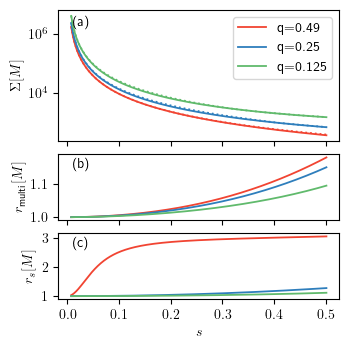

In [47]:
cmap_reds = mpl.colormaps['Reds']
cmap_blues = mpl.colormaps['Blues']
cmap_greens = mpl.colormaps['Greens']
redplot=cmap_reds(.6)
blueplot=cmap_blues(.7)
greenplot=cmap_greens(.55)

fig2 = plt.figure(figsize=(3.375,3.375),layout='constrained')

axs2 = fig2.subplots(3,1,sharex=True,height_ratios=[2,1,1])

axs2[0].semilogy(svals,menos_spade_q0d49,label="q=0.49",color = redplot)
axs2[0].semilogy(svals,menos_spade_q0d49_ub,color = redplot,linestyle=':')

axs2[0].semilogy(svals,menos_spade_q0d25,label="q=0.25",color = blueplot)
axs2[0].semilogy(svals,menos_spade_q0d25_ub,color = blueplot,linestyle=':')

axs2[0].semilogy(svals,menos_spade_q0d125,label="q=0.125",color = greenplot)
axs2[0].semilogy(svals,menos_spade_q0d125_ub,color = greenplot,linestyle=':')

axs2[0].legend()
axs2[0].set_ylabel("$\Sigma[M]$")

axs2[1].plot(svals,r_spade_q0d49,label="q=0.125",color = redplot)
axs2[1].plot(svals,r_spade_q0d25,label="q=0.125",color = blueplot)
axs2[1].plot(svals,r_spade_q0d125,label="q=0.125",color = greenplot)

axs2[1].set_ylabel("$r_{\mathsf{multi}}[M]$")

axs2[2].plot(svals,r_spade_nuisance_q0d49,label="q=0.125",color = redplot)
axs2[2].plot(svals,r_spade_nuisance_q0d25,label="q=0.125",color = blueplot)
axs2[2].plot(svals,r_spade_nuisance_q0d125,label="q=0.125",color = greenplot)

axs2[2].set_ylabel("$r_{s}[M]$")

axs2[2].set_xlabel("$s$")

axs2[0].text(0.05, 0.95, '(a)', transform=axs2[0].transAxes, fontsize='medium',va='top')
axs2[1].text(0.05, 0.95, '(b)', transform=axs2[1].transAxes,fontsize='medium', va='top')
axs2[2].text(0.05, 0.95, '(c)', transform=axs2[2].transAxes,fontsize='medium', va='top');

# fig2.savefig("incoherent_plot.pdf")

In [51]:
qutip.about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Jake Lishman, Simon Cross and Asier Galicia.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.7.5
Numpy Version:      1.26.4
Scipy Version:      1.12.0
Cython Version:     None
Matplotlib Version: 3.7.3
Python Version:     3.11.8
Number of CPUs:     12
BLAS Info:          Generic
OPENMP Installed:   False
INTEL MKL Ext:      False
Platform Info:      Darwin (arm64)
Installation path:  /opt/homebrew/Caskroom/miniforge/base/envs/quantum/lib/python3.11/site-packages/qutip
Please cite QuTiP in your publication.
For your convenience a bibtex refer